# Preprocessing

datasets and bipartite graphs for 1996-2000 and 2018-2022

## libraries

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [4]:

# 1. Load original CSVs
ratings = pd.read_csv("../data/ml-latest/ratings.csv")   # userId, movieId, rating, timestamp
movies  = pd.read_csv("../data/ml-latest/movies.csv")    # movieId, title, genres
tags    = pd.read_csv("../data/ml-latest/tags.csv")      # userId, movieId, tag, timestamp
links   = pd.read_csv("../data/ml-latest/links.csv")     # movieId, imdbId, tmdbId

# 2. Convert Unix timestamp (seconds since epoch) to datetime
#    If your timestamp is already datetime, you can skip this step.
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
tags["datetime"]    = pd.to_datetime(tags["timestamp"], unit="s")


### analysis

In [5]:
min_ts = ratings["timestamp"].min()
max_ts = ratings["timestamp"].max()

min_date = pd.to_datetime(min_ts, unit="s")
max_date = pd.to_datetime(max_ts, unit="s")

print("Oldest rating date:", min_date)
print("Newest rating date:", max_date)

Oldest rating date: 1995-01-09 11:46:44
Newest rating date: 2023-07-20 08:53:33


In [6]:
# how many reviews per year
ratings['year'] = ratings['datetime'].dt.year
reviews_per_year = ratings.groupby('year').size()
print("\nReviews per year:\n", reviews_per_year)



Reviews per year:
 year
1995          4
1996    1732721
1997     763613
1998     329419
1999    1230159
2000    2031258
2001    1237836
2002     909011
2003    1077389
2004    1199108
2005    1844381
2006    1207180
2007    1091850
2008    1202202
2009     978867
2010     967255
2011     819971
2012     779951
2013     621443
2014     566628
2015    1853975
2016    2005979
2017    1899523
2018    1455193
2019    1450218
2020    1763532
2021    1297525
2022     953347
2023     562624
dtype: int64


In [7]:
# how many user reviewed per year
users_per_year = ratings.groupby('year')['userId'].nunique()
print("\nUnique users per year:\n", users_per_year)



Unique users per year:
 year
1995        2
1996    34448
1997    16768
1998     6880
1999    14222
2000    25354
2001    16422
2002    11657
2003    11892
2004    10820
2005    15603
2006    12964
2007    13024
2008    15150
2009    15001
2010    16354
2011    15285
2012    14139
2013    11824
2014    10328
2015    23166
2016    20945
2017    19420
2018    17451
2019    16562
2020    19725
2021    16191
2022    12776
2023     9335
Name: userId, dtype: int64


In [8]:
# number of unique users
num_unique_users = ratings['userId'].nunique()
print("\nNumber of unique users:", num_unique_users)


Number of unique users: 330975


### Size of the datasets

In [9]:
def df_size_info(df, name):
    n_rows, n_cols = df.shape
    print(f"{name}:")
    print(f"  rows: {n_rows:,}")
    print(f"  columns: {n_cols}")

movie_tags = (
    tags
    .sort_values("timestamp")  # keep tags in chronological order
    .groupby("movieId")["tag"]
    .apply(lambda s: " | ".join(s.astype(str)))
    .reset_index()
)

df_size_info(ratings, "ratings")
df_size_info(movies,  "movies")
df_size_info(tags,    "tags")
df_size_info(links,   "links")

ratings:
  rows: 33,832,162
  columns: 6
movies:
  rows: 86,537
  columns: 3
tags:
  rows: 2,328,315
  columns: 5
links:
  rows: 86,537
  columns: 3


In [10]:
# number of reviews are between the period 1996-01-01 and 2000-12-31
start_date1 = pd.to_datetime("1996-01-01")
end_date1   = pd.to_datetime("2000-12-31")

mask1 = (ratings["datetime"] >= start_date1) & (ratings["datetime"] <= end_date1)
filtered_ratings1 = ratings.loc[mask1]
num_reviews_in_period1= filtered_ratings1.shape[0]
print(f"\nNumber of reviews between {start_date1.date()} and {end_date1.date()}: {num_reviews_in_period1}")


Number of reviews between 1996-01-01 and 2000-12-31: 6083034


In [11]:
# number of reviews are between the period 2018-01-01 and 2022-12-31
start_date2 = pd.to_datetime("2018-01-01")
end_date2   = pd.to_datetime("2022-12-31")

mask2 = (ratings["datetime"] >= start_date2) & (ratings["datetime"] <= end_date2)
filtered_ratings2 = ratings.loc[mask2]
num_reviews_in_period2 = filtered_ratings2.shape[0]
print(f"\nNumber of reviews between {start_date2.date()} and {end_date2.date()}: {num_reviews_in_period2}")


Number of reviews between 2018-01-01 and 2022-12-31: 6917880


### tags processing

In [12]:
tags.head()

,userId,movieId,tag,timestamp,datetime
0,10,260,good vs evil,1430666558,2015-05-03 15:22:38
1,10,260,Harrison Ford,1430666505,2015-05-03 15:21:45
2,10,260,sci-fi,1430666538,2015-05-03 15:22:18
3,14,1221,Al Pacino,1311600756,2011-07-25 13:32:36
4,14,1221,mafia,1311600746,2011-07-25 13:32:26


In [13]:
tags_processed = (
    tags
    .groupby(["movieId", "userId"])["tag"]
    .apply(lambda s: " | ".join(s.astype(str))) # Join multiple tags with a pipe
    .reset_index()
)

In [14]:
tags_processed

,movieId,userId,tag
0,1,499,animation | friendship | toys
1,1,1114,animation | Disney | Pixar | toys
2,1,1394,CGI | classic | disney | pixar
3,1,2483,lots of heart
4,1,2612,Tom Hanks
...,...,...,...
446206,288765,236602,bad science | plot holes
446207,288779,185724,Don Camillo Series
446208,288849,95007,addiction | animation | short film
446209,288937,292087,anime


### filtering

In [15]:
def get_cleaned_period_data(ratings_raw, start_year, end_year, min_user_ratings=20, min_movie_ratings=50):
    """
    Takes the RAW ratings dataframe, filters by a specific time period, and applies
    iterative K-Core cleaning (removing users/movies with low activity).
    
    Returns: A cleaned DataFrame ready for graph construction.
    """
    print(f"\n{'='*60}")
    print(f"🔄 PROCESSING PERIOD: {start_year} - {end_year}")
    print(f"{'='*60}")
    
    # --- STEP 1: TEMPORAL PREPROCESSING ---
    # Convert timestamp only if necessary (check if 'year' column exists)
    df = ratings_raw.copy()
    
    if 'year' not in df.columns:
        # Assuming timestamp is in seconds (unit='s')
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        df['year'] = df['datetime'].dt.year
    
    # Filter by years
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()
    
    n_raw = len(df_period)
    u_raw = df_period['userId'].nunique()
    m_raw = df_period['movieId'].nunique()
    
    if n_raw == 0:
        print("❌ ALERT: No ratings found in this period.")
        return None

    print(f"📅 1. Temporal Filter ({start_year}-{end_year}):")
    print(f"   -> Ratings found:     {n_raw:,}")
    print(f"   -> Unique users:      {u_raw:,}")
    print(f"   -> Unique movies:     {m_raw:,}")
    
    # --- STEP 2: ITERATIVE K-CORE FILTERING ---
    print(f"\n🧹 2. K-Core Cleaning (Min User: {min_user_ratings}, Min Movie: {min_movie_ratings})...")
    
    df_core = df_period.copy()
    iteration = 0
    
    while True:
        iteration += 1
        shape_start = df_core.shape[0]
        
        # A. Count frequencies
        user_counts = df_core['userId'].value_counts()
        movie_counts = df_core['movieId'].value_counts()
        
        # B. Identify valid nodes
        valid_users = user_counts[user_counts >= min_user_ratings].index
        valid_movies = movie_counts[movie_counts >= min_movie_ratings].index
        
        # C. Filter the dataframe
        # Using boolean indexing. .isin() is fast.
        df_core = df_core[
            (df_core['userId'].isin(valid_users)) & 
            (df_core['movieId'].isin(valid_movies))
        ]
        
        shape_end = df_core.shape[0]
        
        # D. Check for convergence (if nothing was removed, we are done)
        if shape_start == shape_end:
            break
            
        print(f"   > Iteration {iteration}: reducing to {shape_end:,} ratings...")
            
    # --- STEP 3: FINAL REPORT ---
    n_final = len(df_core)
    u_final = df_core['userId'].nunique()
    m_final = df_core['movieId'].nunique()
    retention = (n_final / n_raw * 100) if n_raw > 0 else 0
    
    print(f"✅ FINISHED after {iteration} iterations.")
    print(f"   -> Final ratings:   {n_final:,} (Retention: {retention:.2f}%)")
    print(f"   -> Core users:      {u_final:,}")
    print(f"   -> Core movies:     {m_final:,}")
    print(f"{'='*60}\n")
    
    return df_core

#### period1: 1996-2000

In [16]:
df_1996_2000_filtered = get_cleaned_period_data(
    ratings, 
    start_year=1996, 
    end_year=2000, 
    min_user_ratings=100, 
    min_movie_ratings=100
)


🔄 PROCESSING PERIOD: 1996 - 2000
📅 1. Temporal Filter (1996-2000):
   -> Ratings found:     6,087,170
   -> Unique users:      90,918
   -> Unique movies:     3,949

🧹 2. K-Core Cleaning (Min User: 100, Min Movie: 100)...
   > Iteration 1: reducing to 3,820,824 ratings...
   > Iteration 2: reducing to 3,800,231 ratings...
   > Iteration 3: reducing to 3,796,050 ratings...
   > Iteration 4: reducing to 3,795,756 ratings...
✅ FINISHED after 5 iterations.
   -> Final ratings:   3,795,756 (Retention: 62.36%)
   -> Core users:      16,955
   -> Core movies:     2,813



In [17]:
df_1996_2000_filtered.head()

,userId,movieId,rating,timestamp,datetime,year
304,7,1,4.0,974518024,2000-11-18 03:27:04,2000
305,7,3,3.0,974517393,2000-11-18 03:16:33,2000
306,7,11,5.0,974520467,2000-11-18 04:07:47,2000
307,7,21,2.0,974518824,2000-11-18 03:40:24,2000
308,7,25,3.0,974519270,2000-11-18 03:47:50,2000


In [18]:
#drop the columns timestamp and datetime
df_1996_2000_filtered = df_1996_2000_filtered.drop(columns=['timestamp', 'datetime'])

In [19]:
df_1996_2000_filtered.head()

,userId,movieId,rating,year
304,7,1,4.0,2000
305,7,3,3.0,2000
306,7,11,5.0,2000
307,7,21,2.0,2000
308,7,25,3.0,2000


#### period2: 2018-2022

In [20]:
df_2018_2022_filtered = get_cleaned_period_data(
    ratings, 
    start_year=2018, 
    end_year=2022, 
    min_user_ratings=100, 
    min_movie_ratings=100
)


🔄 PROCESSING PERIOD: 2018 - 2022
📅 1. Temporal Filter (2018-2022):
   -> Ratings found:     6,919,815
   -> Unique users:      60,274
   -> Unique movies:     74,543

🧹 2. K-Core Cleaning (Min User: 100, Min Movie: 100)...
   > Iteration 1: reducing to 5,118,699 ratings...
   > Iteration 2: reducing to 5,057,332 ratings...
   > Iteration 3: reducing to 5,050,654 ratings...
   > Iteration 4: reducing to 5,050,062 ratings...
✅ FINISHED after 5 iterations.
   -> Final ratings:   5,050,062 (Retention: 72.98%)
   -> Core users:      16,920
   -> Core movies:     5,840



In [21]:
#drop the columns timestamp and datetime
df_2018_2022_filtered = df_2018_2022_filtered.drop(columns=['timestamp', 'datetime'])

In [22]:
df_2018_2022_filtered.head()

,userId,movieId,rating,year
1539,22,18,5.0,2018
1540,22,32,4.5,2018
1541,22,47,4.5,2018
1542,22,70,4.5,2018
1543,22,111,5.0,2018


## build edge list and bipartite graph for the periods

In [23]:
def build_edge_list_strategy_A(
    ratings_filtered,
    movies_df,
    tags_user_df=None,
    edge_csv_name=None
):
    """
    Builds edge list merging tags on specifically (userId, movieId).
    Strategy A: The tag is an attribute of the INTERACTION (Edge), not just the movie.
    """

    # 1. Copy filtered ratings
    df = ratings_filtered.copy()

    # 2. Merge with Movies (Metadata like Title/Genre depends only on MovieId)
    df = df.merge(movies_df, on="movieId", how="left")

    # 3. CRITICAL CHANGE: Merge with Tags using BOTH userId and movieId
    if tags_user_df is not None:
        # We look for matches where User X rated Movie Y AND tagged Movie Y
        df = df.merge(tags_user_df, on=["userId", "movieId"], how="left")
        
        # Fill NaN tags with empty string (common in Strategy A because most users don't tag)
        df["tag"] = df["tag"].fillna("") 
    else:
        df["tag"] = ""

    # 4. Select columns
    cols_to_keep = ["userId", "movieId", "rating", "title", "genres", "tag"]
    edge_list = df[cols_to_keep].copy()
    
    edge_list["weight"] = edge_list["rating"]

    # 5. Create Node IDs
    edge_list["user_node"] = edge_list["userId"].apply(lambda x: f"u_{x}")
    edge_list["movie_node"] = edge_list["movieId"].apply(lambda x: f"m_{x}")

    # 6. Save CSV
    if edge_csv_name is not None:
        edge_list.to_csv(edge_csv_name, index=False)
        print(f"Edge list saved to: {edge_csv_name}")

    return edge_list


def build_bipartite_graph_from_edge_list(edge_list):
    """
    Builds a bipartite graph (NetworkX) from the enriched edge list.
    This function handles metadata attachment efficiently.
    """
    
    # 1. Build graph from the edge list
    # We use user_node and movie_node as identifiers
    print("Building NetworkX graph...")
    G = nx.from_pandas_edgelist(
        edge_list,
        source="user_node",
        target="movie_node",
        edge_attr=["weight", "rating"], # Store the weight in the edge
        create_using=nx.Graph()
    )

    # 2. Mark partitions (Bipartite Sets)
    # Fast approach using sets of created nodes
    user_nodes_set = set(edge_list["user_node"].unique())
    movie_nodes_set = set(edge_list["movie_node"].unique())

    # Assign 'bipartite' attribute
    # 0 for users, 1 for movies (standard NX convention)
    nx.set_node_attributes(G, {n: 0 for n in user_nodes_set}, "bipartite") 
    nx.set_node_attributes(G, {n: 1 for n in movie_nodes_set}, "bipartite") 
    
    # Add string labels for compatibility with visualization scripts
    nx.set_node_attributes(G, {n: "users" for n in user_nodes_set}, "bipartite_label")
    nx.set_node_attributes(G, {n: "movies" for n in movie_nodes_set}, "bipartite_label")

    # 3. Add metadata to MOVIE nodes (Title, Genres)
    # Drop duplicates to iterate only once per unique movie
    movies_attrs = edge_list[["movie_node", "movieId", "title", "genres"]].drop_duplicates("movie_node")
    
    # Use dictionary for bulk update (much faster than iterating rows)
    titles = dict(zip(movies_attrs.movie_node, movies_attrs.title))
    genres = dict(zip(movies_attrs.movie_node, movies_attrs.genres))
    movie_ids = dict(zip(movies_attrs.movie_node, movies_attrs.movieId))

    nx.set_node_attributes(G, titles, "title")
    nx.set_node_attributes(G, genres, "genres")
    nx.set_node_attributes(G, movie_ids, "movieId")

    print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    return G

### period 1

In [24]:
edge_list_1996_2000 = build_edge_list_strategy_A(
        ratings_filtered=df_1996_2000_filtered,
        movies_df=movies,
        tags_user_df=tags_processed,  # Pasamos el DF agrupado por User+Movie
        edge_csv_name="edges_1996_2000.csv"
    )


with_tags = edge_list_1996_2000[edge_list_1996_2000['tag'] != ""]
print(f"Total edges: {len(edge_list_1996_2000):,}")
print(f"Edges with user tags: {len(with_tags):,}")

G_1996_2000 = build_bipartite_graph_from_edge_list(edge_list_1996_2000)

Edge list saved to: edges_1996_2000.csv
Total edges: 3,795,756
Edges with user tags: 1,444
Building NetworkX graph...
Graph built: 19768 nodes, 3795756 edges.


In [25]:
edge_list_1996_2000.head()

,userId,movieId,rating,title,genres,tag,weight,user_node,movie_node
0,7,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,,4.0,u_7,m_1
1,7,3,3.0,Grumpier Old Men (1995),Comedy|Romance,,3.0,u_7,m_3
2,7,11,5.0,"American President, The (1995)",Comedy|Drama|Romance,,5.0,u_7,m_11
3,7,21,2.0,Get Shorty (1995),Comedy|Crime|Thriller,,2.0,u_7,m_21
4,7,25,3.0,Leaving Las Vegas (1995),Drama|Romance,,3.0,u_7,m_25


### period 2

In [26]:
edge_list_2018_2022 = build_edge_list_strategy_A(
        ratings_filtered=df_2018_2022_filtered,
        movies_df=movies,
        tags_user_df=tags_processed,  # Pasamos el DF agrupado por User+Movie
        edge_csv_name="edges_2018_2022.csv"
    )


with_tags = edge_list_2018_2022[edge_list_2018_2022['tag'] != ""]
print(f"Total edges: {len(edge_list_2018_2022):,}")
print(f"Edges with user tags: {len(with_tags):,}")

G_2018_2022 = build_bipartite_graph_from_edge_list(edge_list_2018_2022)

Edge list saved to: edges_2018_2022.csv
Total edges: 5,050,062
Edges with user tags: 81,249
Building NetworkX graph...
Graph built: 22760 nodes, 5050062 edges.


In [27]:
edge_list_2018_2022.head()


,userId,movieId,rating,title,genres,tag,weight,user_node,movie_node
0,22,18,5.0,Four Rooms (1995),Comedy,,5.0,u_22,m_18
1,22,32,4.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,,4.5,u_22,m_32
2,22,47,4.5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,,4.5,u_22,m_47
3,22,70,4.5,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,,4.5,u_22,m_70
4,22,111,5.0,Taxi Driver (1976),Crime|Drama|Thriller,,5.0,u_22,m_111


## description of the bipartite graph

In [28]:
def describe_bipartite(edge_list, G, name="Network"):
    """
    Print basic bipartite stats: #nodes, #edges, degree summary,
    and attention concentration (top 10% movies).
    """
    print(f"===== {name} =====")
    n_edges = len(edge_list)

    users  = edge_list["user_node"].unique()
    movies_nodes = edge_list["movie_node"].unique()

    print(f"Edges (ratings): {n_edges:,}")
    print(f"User nodes:      {len(users):,}")
    print(f"Movie nodes:     {len(movies_nodes):,}")

    # --- user degree stats ---
    user_degrees = [G.degree(u) for u in users]
    print("\nUser degree stats (number of movies rated per user):")
    print(f"  min:   {np.min(user_degrees)}")
    print(f"  max:   {np.max(user_degrees)}")
    print(f"  mean:  {np.mean(user_degrees):.2f}")
    print(f"  median:{np.median(user_degrees):.2f}")
    print(f"  p90:   {np.percentile(user_degrees, 90):.2f}")

    # --- movie degree stats ---
    movie_degrees = [G.degree(m) for m in movies_nodes]
    print("\nMovie degree stats (number of users per movie):")
    print(f"  min:   {np.min(movie_degrees)}")
    print(f"  max:   {np.max(movie_degrees)}")
    print(f"  mean:  {np.mean(movie_degrees):.2f}")
    print(f"  median:{np.median(movie_degrees):.2f}")
    print(f"  p90:   {np.percentile(movie_degrees, 90):.2f}")

    # --- attention concentration: share of ratings on top 10% movies ---
    movie_degree_series = pd.Series(movie_degrees, index=movies_nodes)
    movie_degree_series = movie_degree_series.sort_values(ascending=False)
    top_k = int(0.10 * len(movie_degree_series)) or 1
    top_sum = movie_degree_series.iloc[:top_k].sum()
    total_sum = movie_degree_series.sum()
    share_top = top_sum / total_sum

    print(f"\nAttention concentration:")
    print(f"  Top 10% movies receive {share_top*100:.2f}% of all ratings\n")


In [29]:
describe_bipartite(edge_list_1996_2000, G_1996_2000, name="1996-2000 network")

===== 1996-2000 network =====
Edges (ratings): 3,795,756
User nodes:      16,955
Movie nodes:     2,813

User degree stats (number of movies rated per user):
  min:   100
  max:   2059
  mean:  223.87
  median:168.00
  p90:   408.00

Movie degree stats (number of users per movie):
  min:   100
  max:   11866
  mean:  1349.36
  median:704.00
  p90:   3375.00

Attention concentration:
  Top 10% movies receive 40.36% of all ratings



In [30]:
describe_bipartite(edge_list_2018_2022, G_2018_2022, name="2018-2022 network")


===== 2018-2022 network =====
Edges (ratings): 5,050,062
User nodes:      16,920
Movie nodes:     5,840

User degree stats (number of movies rated per user):
  min:   100
  max:   4385
  mean:  298.47
  median:205.00
  p90:   579.00

Movie degree stats (number of users per movie):
  min:   100
  max:   12241
  mean:  864.74
  median:324.00
  p90:   2216.30

Attention concentration:
  Top 10% movies receive 50.69% of all ratings



## visualize

### normal

In [47]:

def visualize_bipartite_graph(
    G,
    max_users=30,         
    max_movies=30,         
    title=None,
    show_edge_labels=True,
    edge_label_decimals=2,
    max_edges_labeled=50
):
    """
    Visualizes the bipartite graph using the ORIGINAL (minimalist) style,
    but adapted to read 'tags' from edges if they exist.
    """

    # --- 1. Separate nodes (Robust check for 0/1 or "users"/"movies") ---
    user_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") in [0, "users"]]
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") in [1, "movies"]]

    if not user_nodes or not movie_nodes:
        print("Error: No valid 'bipartite' partitions found.")
        return

    # --- 2. Limit nodes (Top Degree) ---
    user_nodes_sorted = sorted(user_nodes, key=lambda n: G.degree(n), reverse=True)
    movie_nodes_sorted = sorted(movie_nodes, key=lambda n: G.degree(n), reverse=True)

    user_nodes_sub = user_nodes_sorted[:max_users]
    movie_nodes_sub = movie_nodes_sorted[:max_movies]

    nodes_to_keep = list(user_nodes_sub) + list(movie_nodes_sub)
    H = G.subgraph(nodes_to_keep).copy()

    # --- 3. Bipartite Layout ---
    # Explicitly define movies_H to avoid NameError
    movies_H = [n for n in H.nodes if n in movie_nodes]
    users_H = [n for n in H.nodes if n in user_nodes]
    
    pos = nx.bipartite_layout(H, movies_H)

    # --- 4. Edge Styling (Restored factor 0.2) ---
    edge_weights = [H[u][v].get("weight", 1.0) for u, v in H.edges()]
    edge_widths = [w * 0.2 for w in edge_weights] 

    plt.figure(figsize=(10, 8)) # Original size

    # --- 5. Draw Nodes (Original Style) ---
    # User nodes: size 100, shape 'o', default color (usually blue)
    nx.draw_networkx_nodes(
        H,
        pos,
        nodelist=users_H,
        node_size=100,
        node_shape="o",
        label="Users"
    )

    # Movie nodes: size 200, shape 's', default color
    nx.draw_networkx_nodes(
        H,
        pos,
        nodelist=movies_H,
        node_size=200,
        node_shape="s",
        label="Movies"
    )

    # --- 6. Draw Edges ---
    nx.draw_networkx_edges(
        H,
        pos,
        width=edge_widths
    )

    # --- 7. Node Labels (Movies) ---
    movie_labels = {}
    for n in movies_H:
        # Use title if it exists, otherwise use ID
        movie_labels[n] = H.nodes[n].get("title", str(n))

    nx.draw_networkx_labels(
        H,
        pos,
        labels=movie_labels,
        font_size=8
    )

    # --- 8. Edge Labels (Rating + Tag) ---
    if show_edge_labels:
        edge_labels_dict = {}
        
        # Collect data to prioritize labels with text
        edges_data = []
        for u, v, data in H.edges(data=True):
            w = data.get("weight", 0.0)
            t = data.get("tag", "") # Extract tag from Strategy A
            # Priority: 1 if has tag, 0 if not
            has_tag = 1 if (t and isinstance(t, str) and len(t) > 0) else 0
            edges_data.append((u, v, w, t, has_tag))

        # Sort to show those with tags first, then by weight
        edges_data.sort(key=lambda x: (x[4], x[2]), reverse=True)
        edges_to_draw = edges_data[:max_edges_labeled]

        for u, v, w, t, has_tag in edges_to_draw:
            # Simple format: "4.0" or "4.0\n[tag]"
            label_str = f"{w:.{edge_label_decimals}f}"
            if has_tag:
                label_str += f"\n[{t}]"
            
            edge_labels_dict[(u, v)] = label_str

        # Draw without white boxes (clean original style)
        nx.draw_networkx_edge_labels(
            H,
            pos,
            edge_labels=edge_labels_dict,
            font_size=7
        )

    # --- 9. Final touches ---
    plt.axis("off")
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

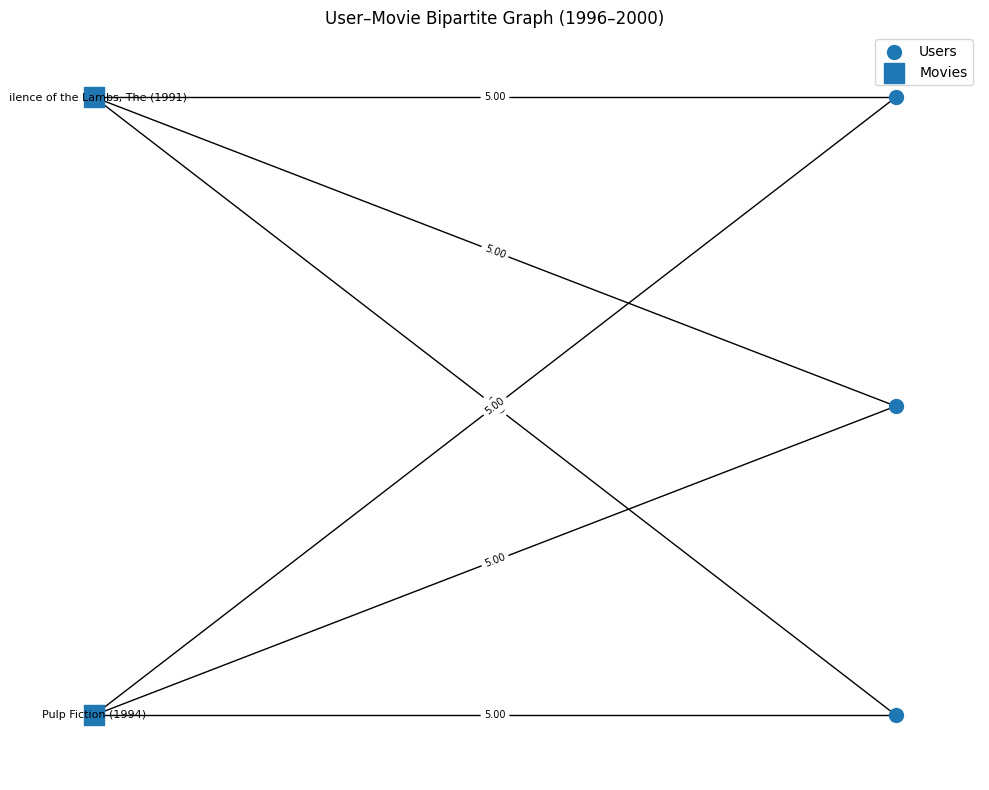

In [48]:
# Grafo 2000–2005
visualize_bipartite_graph(
    G_1996_2000,
    max_users=3,
    max_movies=2,
    title="User–Movie Bipartite Graph (1996–2000)",
    show_edge_labels=True,
    edge_label_decimals=2,
    max_edges_labeled=50
)

### shell

bc sometimes this visualization its cleaner

In [ ]:


def visualize_bipartite_shell(
    G,
    max_users=30,
    max_movies=30,
    title=None,
    show_edge_labels=True,
    edge_label_decimals=2, 
    max_edges_labeled=30
):
    """
    Visualize the bipartite graph in a Shell (circular) layout
    using the classic (minimalist) style, with support for edge tags.

    - Inner circle: Movies
    - Outer circle: Users
    """

    # --- 1. Separate partitions (Robust Check 0/1 or strings) ---
    user_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") in [0, "users"]]
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") in [1, "movies"]]

    if not user_nodes or not movie_nodes:
        print("Error: Graph does not have valid 'bipartite' attributes.")
        return

    # --- 2. Limit nodes (Top Degree) ---
    user_nodes_sorted = sorted(user_nodes, key=lambda n: G.degree(n), reverse=True)
    movie_nodes_sorted = sorted(movie_nodes, key=lambda n: G.degree(n), reverse=True)

    # Correct slicing
    user_nodes_sub = user_nodes_sorted[:max_users]
    movie_nodes_sub = movie_nodes_sorted[:max_movies]

    # Create Subgraph
    nodes_to_keep = list(user_nodes_sub) + list(movie_nodes_sub)
    H = G.subgraph(nodes_to_keep).copy()

    # Define local lists for H
    users_H = [n for n in H.nodes if n in user_nodes]
    movies_H = [n for n in H.nodes if n in movie_nodes]

    # --- 3. Shell Layout ---
    # nlist defines concentric rings (Inner -> Outer)
    # movies_H inside, users_H outside
    pos = nx.shell_layout(H, nlist=[movies_H, users_H])

    # --- 4. Edge Styling (Classic width 0.2) ---
    edge_weights = [H[u][v].get("weight", 1.0) for u, v in H.edges()]
    edge_widths = [w * 0.2 for w in edge_weights]

    plt.figure(figsize=(10, 10)) # Square figure to avoid deforming the circle

    # --- 5. Draw Nodes (Classic Style) ---
    # Movies (Inner)
    nx.draw_networkx_nodes(
        H, pos, nodelist=movies_H, node_size=200, 
        node_shape="s", label="Movies"
        # No specific node_color -> uses default (usually blue/red depending on version)
    )

    # Users (Outer)
    nx.draw_networkx_nodes(
        H, pos, nodelist=users_H, node_size=100, 
        node_shape="o", label="Users"
    )

    # Draw Edges
    nx.draw_networkx_edges(H, pos, width=edge_widths)

    # --- 6. Node Labels (Titles) ---
    movie_labels = {}
    for n in movies_H:
        full_title = H.nodes[n].get("title", str(n))
        # Shorten very long titles for the circle layout
        short_title = full_title[:20] + "..." if len(full_title) > 20 else full_title
        movie_labels[n] = short_title

    nx.draw_networkx_labels(H, pos, labels=movie_labels, font_size=8)

    # --- 7. Edge Labels (Ratings + Tags) ---
    if show_edge_labels:
        edge_labels_dict = {}
        
        # Collect data
        edges_data = []
        for u, v, data in H.edges(data=True):
            w = data.get("weight", 0.0)
            t = data.get("tag", "")
            # Priority if it has a tag
            has_tag = 1 if (t and isinstance(t, str) and len(t) > 0) else 0
            edges_data.append((u, v, w, t, has_tag))

        # Sort: Tags first, then high rating
        edges_data.sort(key=lambda x: (x[4], x[2]), reverse=True)
        edges_to_draw = edges_data[:max_edges_labeled]

        # Build String
        for u, v, w, t, has_tag in edges_to_draw:
            label_str = f"{w:.{edge_label_decimals}f}"
            if has_tag:
                label_str += f"\n[{t}]"
            
            edge_labels_dict[(u, v)] = label_str

        # Draw labels (Clean style without white boxes)
        nx.draw_networkx_edge_labels(
            H,
            pos,
            edge_labels=edge_labels_dict,
            font_size=7
        )

    # --- 8. Final touches ---
    plt.axis("off")
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

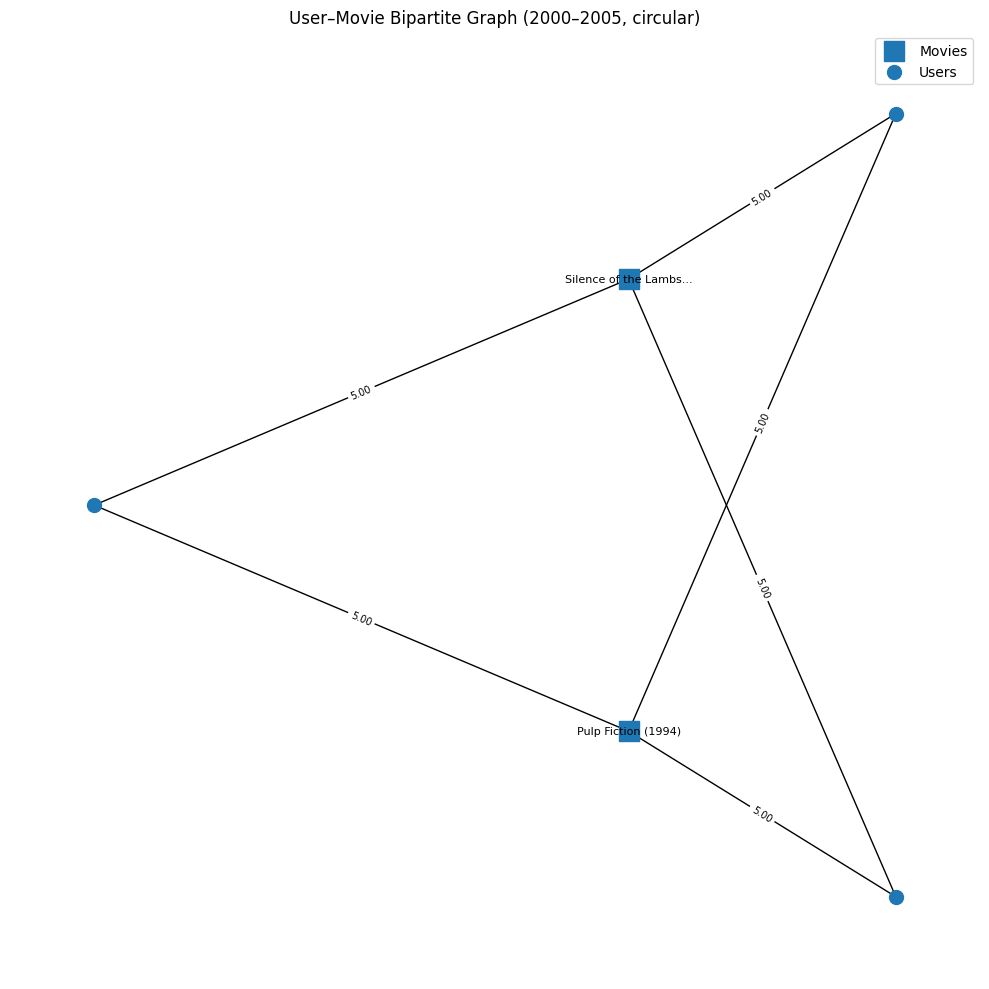

In [46]:
visualize_bipartite_shell(
    G_1996_2000,
    max_users=3,
    max_movies=2,
    title="User–Movie Bipartite Graph (2000–2005, circular)"
)